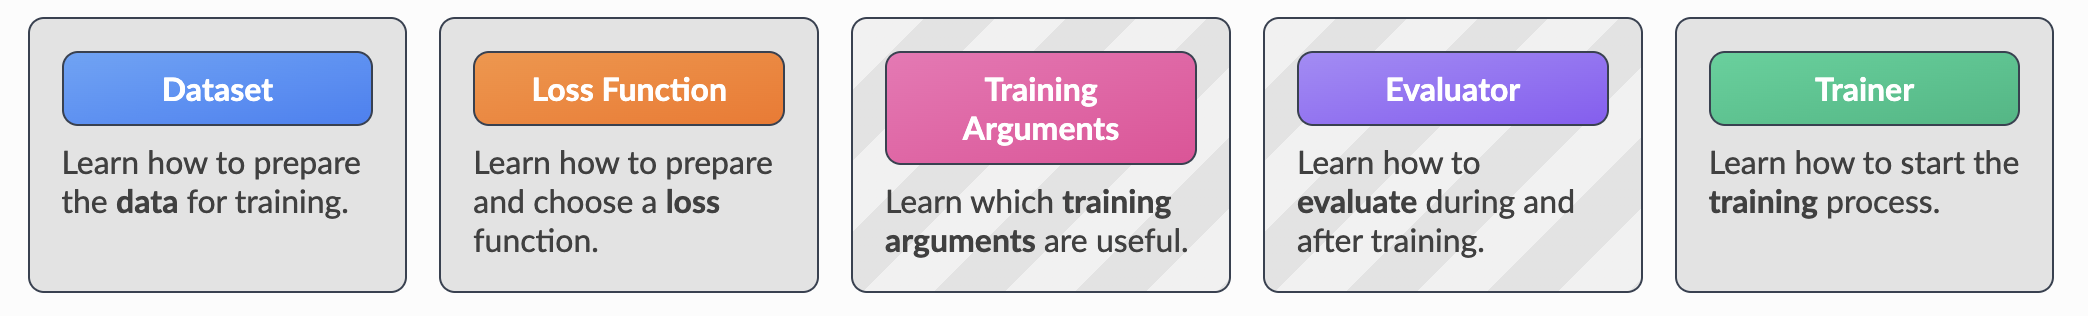

### Loss Functions
Loss functions quantify how well a model perfroms for a given batch of data, allowing the optimizer to update the model weights to produce more favourable (i.e., lower) loss values. This is the core training process.

There is not single best loss function that works best for all use-cases. Instead which loss function to use greatly depends on your data and on your target task. 


### Contrastive Loss
Contrastive Loss expects as input two texts and label of either 0 or 1. If the label == 1, then the distance between the two embeddings is reduced. If label ==0, then the distance between the embeddigs is increased.



Let's dive into how Online Contrastive Learning, specifically in the context of the OnlineContrastiveLoss in sentence-transformers, computes similarities and finds the hardest positives and negatives within a batch.
- Batch Preparation:The batch consists of sentence embeddings and their corresponding labels.
- Similarity Computation: For each anchor in the batch, the model computes its similarity with all other samples in the batch. This is typically done using cosine similarity; This results in a similarity matrix where each element (i,j) represents the similarity between the i-th and j-th samples in the batch.
- Finding Hardest Positives and Negatives: for each anchor: a. Hardest Positive. Identify all other samples with the same label as the anchor. Among these, find the one with the lowest similarity score (cosine similarity) to the anchor. This is the "hardest positive" because it's the most dissimilar sample that should be similar.
- Hardest Negative: Identify all samples with different labels from the anchor. Among these, find the one with the highest similarity score to the anchor. This is the "hardest negative" because it's the most similar sample that should be different.
- Loss Computation: The contrastive loss is then computed using these hardest pairs. The goal is to minimize the distance between the anchor and its hardest positive while maximizing the distance between the anchor and its hardest negative.
     - `loss = max(0, pos_distance - neg_distance + margin)`
- Backpropagation: The loss is then backpropagated through the network, updating the model weights to improve its ability to distinguish between similar and dissimilar pairs.


This process of finding the hardest examples within each batch helps the model focus on the most challenging cases, potentially leading to more robust learning. It's particularly useful in scenarios where the distinction between similar and dissimilar items can be subtle, as is often the case with business names.


In the context of your business name similarity task, this approach would help the model learn to distinguish between subtle variations of the same business name (like "HANAN TAHER TRUCKING" and "TRUCKING INC HANAN ATHER") while still recognizing them as similar, and to differentiate them from truly different businesses (like "HANAN ATHER PHARMACY INC").

In [3]:
from datasets import load_dataset  
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CoSENTLoss

1. Data Preparation:
- Instead of pairs, we'll prepare individual business names with labels. The labels could be unique identifiers for each business entity.
2. We'll need to change how we create our training examples and use OnlineContrastiveLoss.
3. Adjust the evaluation process: We need to modify our evaluation to work with individual names rather than pairs.
4. The main loop remains largely the same, but we'll use our new data preparation method.

In [8]:
def prepare_business_names(n=5000):
    industries = ['Tech', 'Finance', 'Healthcare', 'Retail', 'Manufacturing']
    suffixes = ['Inc', 'LLC', 'Corp', 'Co', '']
    
    business_data = []
    for i in range(n):
        industry = random.choice(industries)
        base_name = f"{fake.company()} {random.choice(suffixes)}"
        business_id = i  # Unique identifier for each business
        
        # Create variations of the same business
        business_data.extend([
            (base_name, business_id),
            (f"{base_name} {industry}", business_id),
            (' '.join(reversed(base_name.split())), business_id),
            (base_name.replace('Inc', 'Incorporated'), business_id),
            (f"{base_name[:len(base_name)//2]}", business_id)
        ])
    
    return business_data

# Generate dataset
dataset = prepare_business_names()

In [9]:
dataset

[('Walker Inc Co', 0),
 ('Walker Inc Co Retail', 0),
 ('Co Inc Walker', 0),
 ('Walker Incorporated Co', 0),
 ('Walker', 0),
 ('Welch, White and Evans LLC', 1),
 ('Welch, White and Evans LLC Finance', 1),
 ('LLC Evans and White Welch,', 1),
 ('Welch, White and Evans LLC', 1),
 ('Welch, White ', 1),
 ('Wolfe LLC Co', 2),
 ('Wolfe LLC Co Manufacturing', 2),
 ('Co LLC Wolfe', 2),
 ('Wolfe LLC Co', 2),
 ('Wolfe ', 2),
 ('Valenzuela Ltd Co', 3),
 ('Valenzuela Ltd Co Manufacturing', 3),
 ('Co Ltd Valenzuela', 3),
 ('Valenzuela Ltd Co', 3),
 ('Valenzue', 3),
 ('Schultz, Mckay and Johnson Co', 4),
 ('Schultz, Mckay and Johnson Co Tech', 4),
 ('Co Johnson and Mckay Schultz,', 4),
 ('Schultz, Mckay and Johnson Co', 4),
 ('Schultz, Mckay', 4),
 ('Roberts LLC Co', 5),
 ('Roberts LLC Co Tech', 5),
 ('Co LLC Roberts', 5),
 ('Roberts LLC Co', 5),
 ('Roberts', 5),
 ('Johnson, Burns and Zimmerman ', 6),
 ('Johnson, Burns and Zimmerman  Retail', 6),
 ('Zimmerman and Burns Johnson,', 6),
 ('Johnson, Burns

In [10]:
import pandas as pd
from Levenshtein import distance as levenshtein_distance
from nltk.util import ngrams
from jellyfish import jaro_winkler_similarity
from sentence_transformers import SentenceTransformer, InputExample, losses
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random
from faker import Faker


def generate_business_name():
    components = [
        fake.last_name(),
        fake.last_name(),
        random.choice(['Trucking', 'Logistics', 'Transport', 'Shipping', 'Freight']),
        random.choice(['Inc', 'LLC', 'Co', 'Corporation', ''])
    ]
    return ' '.join(components)

def create_variation(name, variation_type):
    words = name.split()
    if variation_type == 'typo':
        index = random.randint(0, len(words) - 1)
        words[index] = ''.join(random.sample(words[index], len(words[index])))
    elif variation_type == 'abbreviation':
        index = random.randint(0, len(words) - 1)
        words[index] = words[index][0] + '.'
    elif variation_type == 'word_order':
        random.shuffle(words)
    elif variation_type == 'missing_word':
        words.pop(random.randint(0, len(words) - 1))
    elif variation_type == 'added_word':
        words.insert(random.randint(0, len(words)), fake.word())
    return ' '.join(words)

def generate_dataset(n_pairs=10000):
    dataset = []
    for _ in range(n_pairs):
        if random.random() < 0.7:  # 70% similar pairs
            base_name = generate_business_name()
            variation_type = random.choice(['typo', 'abbreviation', 'word_order', 'missing_word', 'added_word'])
            variation = create_variation(base_name, variation_type)
            similarity = random.uniform(0.7, 1.0)  # High similarity for variations
            dataset.append((base_name, variation, similarity))
        else:  # 30% dissimilar pairs
            name1 = generate_business_name()
            name2 = generate_business_name()
            similarity = random.uniform(0.0, 0.3)  # Low similarity for different businesses
            dataset.append((name1, name2, similarity))
    return dataset

def fine_tune_model(train_data, val_data, epochs=5):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    train_examples = [InputExample(texts=[name1, name2], label=float(similarity)) for name1, name2, similarity in train_data]
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=epochs,
              warmup_steps=100,
              evaluation_steps=500,
              output_path='output')
    return model

# Generate dataset and fine-tune model
full_dataset = generate_dataset()
full_dataset

[('Ferguson Richardson Freight ',
  'Richardson Freight Ferguson',
  0.8334575954054856),
 ('Ortiz Harrison Freight LLC',
  'Ortiz nriHaosr Freight LLC',
  0.8195675565245164),
 ('Dominguez Dickson Freight Co',
  'Co Dickson Dominguez Freight',
  0.8112940515094624),
 ('Hall Gallagher Trucking ', 'Gallagher Hall Trucking', 0.7484081274205143),
 ('Logan Ramirez Logistics Inc',
  'Ramirez Logan Inc Logistics',
  0.9312301784806232),
 ('Perez Montgomery Logistics LLC',
  'Perez Montgomery Logistics',
  0.916728811562391),
 ('Hall Wheeler Trucking LLC',
  'Hall rlWeehe Trucking LLC',
  0.9289533698032416),
 ('Roberson Torres Shipping LLC',
  'Roberson Torres LLC Shipping',
  0.8117410720422789),
 ('Owen Thomas Transport Co', 'Martinez Silva Freight Co', 0.1533789766496734),
 ('Foley Vincent Freight LLC', 'Vincent Freight LLC', 0.8919223663687208),
 ('Taylor Morales Shipping Co',
  'Hensley George Trucking Corporation',
  0.16760761957620066),
 ('Campbell Sanford Shipping Corporation',
  'C

In [11]:
import random
from faker import Faker
import numpy as np
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

fake = Faker()

def generate_business_name():
    components = [
        fake.last_name(),
        fake.last_name(),
        random.choice(['Trucking', 'Logistics', 'Transport', 'Shipping', 'Freight']),
        random.choice(['Inc', 'LLC', 'Co', 'Corporation', ''])
    ]
    return ' '.join(components)

def create_variation(name, variation_type):
    words = name.split()
    if variation_type == 'typo':
        index = random.randint(0, len(words) - 1)
        words[index] = ''.join(random.sample(words[index], len(words[index])))
    elif variation_type == 'abbreviation':
        index = random.randint(0, len(words) - 1)
        words[index] = words[index][0] + '.'
    elif variation_type == 'word_order':
        random.shuffle(words)
    elif variation_type == 'missing_word':
        if len(words) > 1:
            words.pop(random.randint(0, len(words) - 1))
    elif variation_type == 'added_word':
        words.insert(random.randint(0, len(words)), fake.word())
    return ' '.join(words)

def generate_dataset(n_pairs=10000):
    dataset = []
    for _ in range(n_pairs):
        if random.random() < 0.5:  # 50% similar pairs
            base_name = generate_business_name()
            variation_type = random.choice(['typo', 'abbreviation', 'word_order', 'missing_word', 'added_word'])
            variation = create_variation(base_name, variation_type)
            dataset.append((base_name, variation, 1))  # 1 indicates similar
        else:  # 50% dissimilar pairs
            name1 = generate_business_name()
            name2 = generate_business_name()
            dataset.append((name1, name2, 0))  # 0 indicates dissimilar
    return dataset

# Generate dataset
full_dataset = generate_dataset()
full_dataset

[('Blake Phillips Freight Inc', 'B. Phillips Freight Inc', 1),
 ('Williams Rollins Transport Inc', 'lslWiami Rollins Transport Inc', 1),
 ('Hardy Williams Logistics Inc', 'George Johnson Trucking ', 0),
 ('Tyler Patel Transport Co', 'Tyler Patel Transport', 1),
 ('Morales Beck Freight Inc', 'Benjamin Freeman Transport ', 0),
 ('Cruz Wood Logistics Inc', 'Martin Woods Freight Corporation', 0),
 ('Rivera Lee Freight Co', 'Moore Whitaker Transport LLC', 0),
 ('Sanchez Gregory Transport LLC', 'Sanchez G. Transport LLC', 1),
 ('Ramirez Spencer Transport Corporation', 'Kelly Lee Trucking Inc', 0),
 ('Stephens Johnson Transport Corporation',
  'Johnson Transport Corporation Stephens',
  1),
 ('King Joseph Logistics Inc', 'Davis Gordon Freight Corporation', 0),
 ('Williams Holmes Freight Inc', 'Holmes Freight Inc', 1),
 ('Hoffman Mccormick Transport Inc',
  'Hoffman Mccormick personal Transport Inc',
  1),
 ('Martinez Russell Transport Co', 'Martinez Brooks Shipping Inc', 0),
 ('Davila Richard